# Polynômes de chaos : application au cas de la poutre encastrée avec chaos par intégration - Solution

In [1]:
import openturns as ot
import openturns.viewer as otv

In [2]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * (L ** 3) / (3 * E * I)
    return [Y]


g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Créer le polynôme

On crée la base polynomiale multivariée par tensorisation de polynômes univariés avec la règle d'énumération linéaire par défaut.

In [3]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [dist_E, dist_F, dist_L, dist_I]
)

In [4]:
totalDegree = 5
enumerateFunction = multivariateBasis.getEnumerateFunction()
strataIndex = enumerateFunction.getMaximumDegreeStrataIndex(totalDegree)
maximumBasisSize = enumerateFunction.getStrataCumulatedCardinal(strataIndex)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, maximumBasisSize)
adaptiveStrategy

class=FixedStrategy derived from class=AdaptiveStrategyImplementation maximumDimension=126

In [5]:
distributionStandard = multivariateBasis.getMeasure()
distributionStandard

class=ComposedDistribution name=ComposedDistribution dimension=4 copula=class=IndependentCopula name=IndependentCopula dimension=4 marginal[0]=class=Beta name=Beta dimension=1 alpha=0.9 beta=2.2 a=-1 b=1 marginal[1]=class=LogNormal name=LogNormal dimension=1 muLog=9.46206 sigmaLog=0.554513 gamma=0 marginal[2]=class=Uniform name=Uniform dimension=1 a=-1 b=1 marginal[3]=class=Beta name=Beta dimension=1 alpha=2.5 beta=1.5 a=-1 b=1

In [6]:
marginalSize = [4] * dim_input
experiment = ot.GaussProductExperiment(distributionStandard, marginalSize)

experiment.generate().getSize()

256

In [7]:
projectionStrategy = ot.IntegrationStrategy(experiment)

chaosalgo = ot.FunctionalChaosAlgorithm(
    g, myDistribution, adaptiveStrategy, projectionStrategy
)
chaosalgo.run()

result = chaosalgo.getResult()

metamodel = result.getMetaModel()

## Validate the metamodel

In [8]:
n_valid = 1000
inputTest = myDistribution.getSample(n_valid)
outputTest = g(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [9]:
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)

Compute the $Q^2$ predictivity coefficient

In [10]:
Q2 = val.computePredictivityFactor()[0]
Q2

0.9999575691056145

Plot the observed versus the predicted outputs.

/home/devel/miniconda3/envs/otsupgalilee/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/devel/miniconda3/envs/otsupgalilee/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


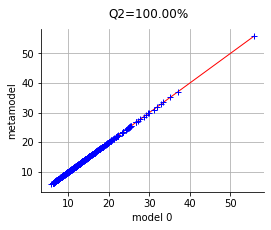

In [11]:
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (Q2 * 100))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que les coefficients sont relativement bien estimés puisque le Q2 est excellent (parfait ?), malgré un nombre de points relativement réduit dans le plan d'expériences (256 points).

## Solution de l'exercice 1 : changer de méthode de quadrature


In [20]:
def ComputeFullIntegrationChaos(
    g_function, multivariateBasis, totalDegree, myDistribution, experiment
):
    """
    Create a full polynomial chaos with integration based on Gaussian quadrature.

    * Uses the enumeration rule from multivariateBasis.
    * Uses IntegrationStrategy to compute the coefficients using
    integration.
    * Uses FixedStrategy to keep all coefficients.

    When the number of input variables
    or the required marginal degree is large, the design of experiments is
    very large.

    Parameters
    ----------
    g_function : ot.Function
        The function to create the metamodel from.
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The total polynomial degree.
        The total degree is the sum of the marginal degrees.
    myDistribution : ot.Distribution
        The distribution of the input random vector
    experiment : ot.WeightedExperiment
        The design of experiment for quadrature

    Returns
    -------
    result : ot.FunctionalChaosResult
        The polynomial chaos result
    """
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    strataIndex = enumerateFunction.getMaximumDegreeStrataIndex(totalDegree)
    maximumBasisSize = enumerateFunction.getStrataCumulatedCardinal(strataIndex)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, maximumBasisSize)
    projectionStrategy = ot.IntegrationStrategy(experiment)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        g_function, myDistribution, adaptiveStrategy, projectionStrategy
    )
    return chaosalgo

In [21]:
def computeChaosAndValidate(
    totalDegree,
    g_function,
    multivariateBasis,
    myDistribution,
    experiment,
    sampleSizeValidation,
):
    chaosalgo = ComputeFullIntegrationChaos(
        g_function, multivariateBasis, totalDegree, myDistribution, experiment
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    metamodel = result.getMetaModel()

    inputTest = myDistribution.getSample(sampleSizeValidation)
    outputTest = g(inputTest)

    val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
    Q2 = val.computePredictivityFactor()[0]
    print("Q2=%.2f%%" % (Q2 * 100))
    return

In [23]:
totalDegree = 5
marginalSize = [4] * dim_input
experiment = ot.GaussProductExperiment(distributionStandard, marginalSize)
sampleSizeValidation = 1000
computeChaosAndValidate(
    totalDegree, g, multivariateBasis, myDistribution, experiment, sampleSizeValidation
)

Q2=100.00%


In [31]:
totalDegree = 2
size = 10000
experiment = ot.MonteCarloExperiment(distributionStandard, size)
sampleSizeValidation = 1000
computeChaosAndValidate(
    totalDegree, g, multivariateBasis, myDistribution, experiment, sampleSizeValidation
)

Q2=96.70%


In [38]:
totalDegree = 3
size = 10000
sequence = ot.SobolSequence()
experiment = ot.LowDiscrepancyExperiment(sequence, distributionStandard, size)
sampleSizeValidation = 1000
computeChaosAndValidate(
    totalDegree, g, multivariateBasis, myDistribution, experiment, sampleSizeValidation
)

Q2=99.02%


## Solution de l'exercice 2

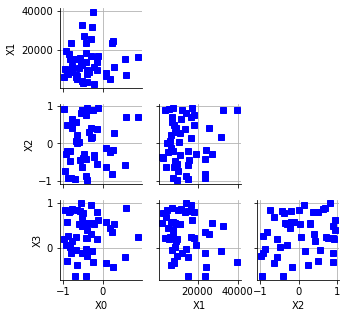

In [17]:
size = 50
experiment = ot.MonteCarloExperiment(distributionStandard, size)
sample = experiment.generate()
graph = ot.VisualTest.DrawPairs(sample)
view = otv.View(graph, figure_kw={"figsize": (5.0, 5.0)})

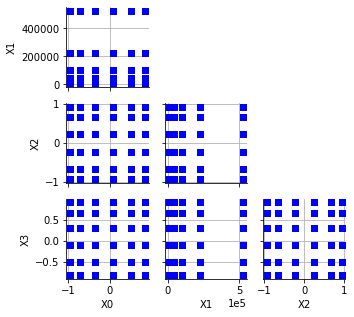

In [18]:
marginalSize = [6] * dim_input
experiment = ot.GaussProductExperiment(distributionStandard, marginalSize)
sample = experiment.generate()
graph = ot.VisualTest.DrawPairs(sample)
view = otv.View(graph, figure_kw={"figsize": (5.0, 5.0)})

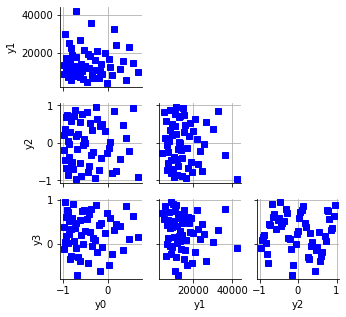

In [19]:
size = 56
sequence = ot.SobolSequence()
experiment = ot.LowDiscrepancyExperiment(sequence, distributionStandard, size, True)
sample = experiment.generate()
graph = ot.VisualTest.DrawPairs(sample)
view = otv.View(graph, figure_kw={"figsize": (5.0, 5.0)})